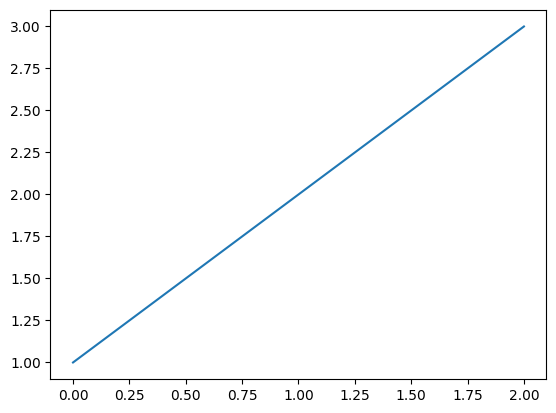

In [1]:
import matplotlib.pyplot as plt
plt.plot([1,2,3])

In [2]:
import torch
import numpy as np


In [3]:
np.random.seed(42)

In [4]:
x_obs = np.hstack([np.linspace(-0.2,0.2,500),np.linspace(0.6,1,500)])

In [5]:
noise = 0.02 * np.random.randn(x_obs.shape[0])

In [6]:
y_obs = x_obs + 0.3 * np.sin(2 * np.pi * (x_obs+noise))+ 0.3 * \
                            np.sin(4 * np.pi * (x_obs+noise)) + noise

In [7]:
x_true = np.linspace(-0.5,1.5,1000)

In [8]:
y_true = x_true + 0.3*np.sin(2 * np.pi * x_true) + 0.3 * \
                            np.sin(4 * np.pi * x_true)

In [9]:
xlims = [-0.5,1.5]
ylims = [-1.5,2.5]

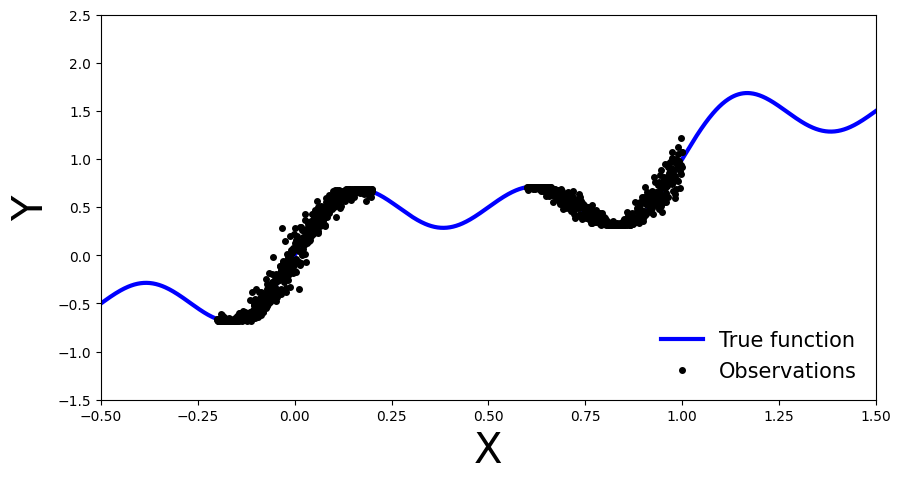

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_true,y_true,'b-',linewidth=3,label='True function')
ax.plot(x_obs,y_obs,'ko',markersize=4,label='Observations')
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel('X',fontsize=30)
ax.set_ylabel('Y',fontsize=30)
ax.legend(loc=4,fontsize=15,frameon=False)

In [11]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

In [12]:
class BNN(PyroModule):
    def __init__(self,in_dim=1,out_dim=1,hid_dim=5,prior_scale=10.):
        super().__init__()
        
        self.activation = nn.Tanh()
        self.layer1 = PyroModule[nn.Linear](in_dim,hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim,out_dim)
        
        self.layer1.weight = PyroSample(dist.Normal(0.,prior_scale).expand([hid_dim,in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0.,prior_scale).expand([hid_dim]).to_event(1))
        
        self.layer2.weight = PyroSample(dist.Normal(0.,prior_scale).expand([out_dim,hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0.,prior_scale).expand([out_dim]).to_event(1))
        
    def forward(self,x,y=None):
        x = x.reshape(-1,1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample('sigma',dist.Gamma(.5,1))
        
        with pyro.plate('data',x.shape[0]):
            obs = pyro.sample('obs',dist.Normal(mu,sigma**2),obs=y)
        return mu
                                

In [28]:
from pyro.infer import MCMC, NUTS

model = BNN()

pyro.set_rng_seed(42)

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel,num_samples=50)

x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

mcmc.run(x_train,y_train)

Sample: 100%|█████████████████████████████████████████| 100/100 [05:07,  3.08s/it, step size=6.71e-04, acc. prob=0.742]


In [29]:
from pyro.infer import Predictive

In [30]:
predictive = Predictive(model=model,posterior_samples=mcmc.get_samples())
x_test = torch.linspace(xlims[0],xlims[1],3000)
preds_mcmc = predictive(x_test)

In [31]:
preds_mcmc

{'obs': tensor([[-0.5782, -0.4745, -0.4330,  ...,  1.9330,  1.7531,  1.8977],
         [-0.3904, -0.3693, -0.2173,  ...,  2.0469,  2.0577,  2.0436],
         [-0.4403, -0.5386, -0.5305,  ...,  1.8439,  1.7718,  1.7824],
         ...,
         [-0.5244, -0.3689, -0.5213,  ...,  3.2782,  3.2007,  3.4162],
         [-0.3312, -0.3256, -0.4390,  ...,  3.2692,  3.1728,  3.2694],
         [-0.2058, -0.4267, -0.4103,  ...,  3.2530,  3.3596,  3.3291]])}

In [32]:
preds_mcmc['obs'].shape

torch.Size([50, 3000])

In [33]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)
    
    fig, ax = plt.subplots(figsize=(10,5))
    xlims = [-0.5,1.5]
    ylims = [-1.5,2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel('X',fontsize=30)
    plt.ylabel('Y',fontsize=30)
    
    ax.plot(x_true,y_true,'b-',linewidth=3,label='true function')
    ax.plot(x_obs,y_obs,'ko',markersize=4,label='observations')
    ax.plot(x_test,y_pred,'-',linewidth=3,color='#408765',label='predictive mean')
    ax.fill_between(x_test,y_pred-2*y_std,y_pred+2*y_std,alpha=0.6,color='#86cfac',zorder=5)
    
    plt.legend(loc=4,fontsize=15,frameon=False)

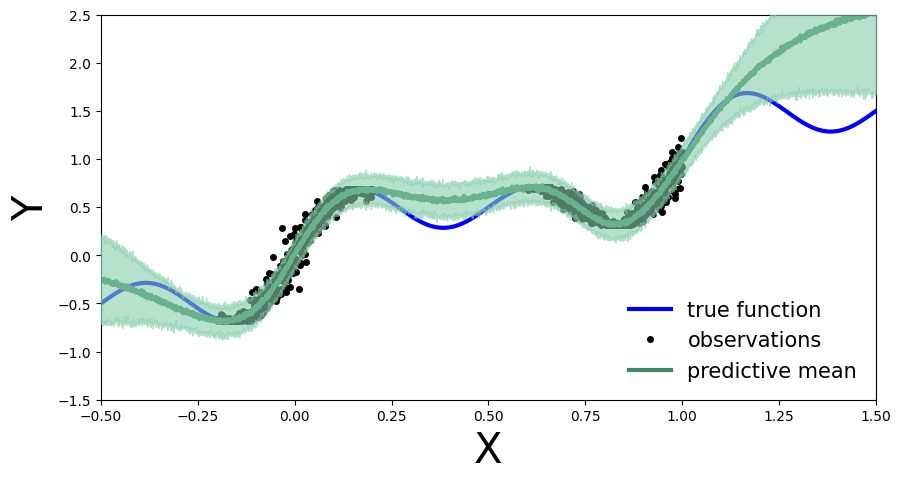

In [34]:
plot_predictions(preds_mcmc)

## Variational Inference

In [35]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal,AutoNormal
from tqdm import trange
pyro.clear_param_store()

In [36]:
model = BNN()
mean_field_guide = AutoNormal(model)
optimizer = pyro.optim.Adam({'lr':0.01})

In [37]:
svi = SVI(model,mean_field_guide,optimizer,loss=Trace_ELBO())

In [38]:
num_epochs = 25000
progress_bar = trange(num_epochs)

  0%|                                                                                        | 0/25000 [00:00<?, ?it/s]

In [39]:
for epoch in progress_bar:
    loss = svi.step(x_train,y_train)
    progress_bar.set_postfix(loss=f"{loss /x_train.shape[0]:.3f}")

100%|███████████████████████████████████████████████████████████████| 25000/25000 [07:07<00:00, 58.51it/s, loss=-1.023]


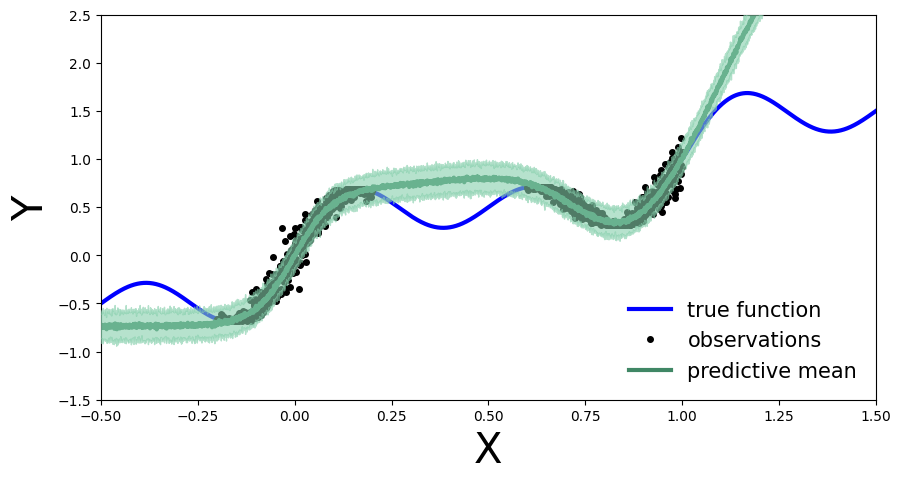

In [40]:
predictive = Predictive(model,guide=mean_field_guide,num_samples=50)
preds = predictive(x_test)
plot_predictions(preds)